In [3]:
import os
import ramdom
import numpy as np
import yfinance as yf
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm 
from matplotlib import pyplot as plt
%matplotlib inline

/Users/apple/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# data of stocks
stocks = ["ADBE",'MSFT']
start_date = "2020-01-01"
end_date= "2023-12-31"
df = yf.download(stocks,start=start_date,end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2020-01-02,334.429993,153.630707
2020-01-03,331.809998,151.717728
2020-01-06,333.709991,152.109848
2020-01-07,333.390015,150.722992
2020-01-08,337.869995,153.123749


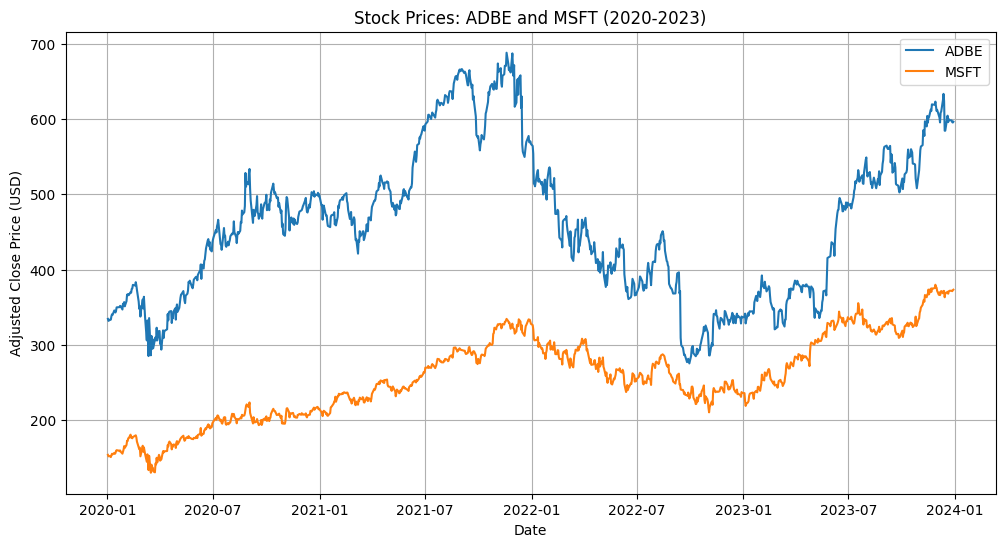

Ticker         ADBE         MSFT
count   1006.000000  1006.000000
mean     459.583559   256.641233
std      100.110992    55.341066
min      275.200012   129.881042
25%      373.617500   214.892288
50%      460.029999   253.355362
75%      519.614975   296.604370
max      688.369995   379.859467


In [5]:
# Plotting stock prices
plt.figure(figsize=(12, 6))
for stock in df.columns:
    plt.plot(df[stock], label=stock)

plt.title('Stock Prices: ADBE and MSFT (2020-2023)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics for both stocks
summary = df.describe()
print(summary)

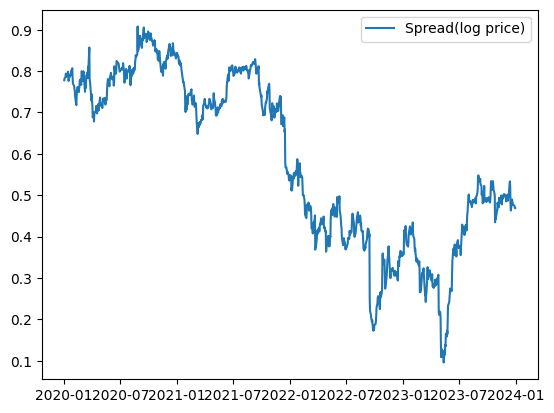

In [6]:
spread = np.log(df[stocks[0]])-np.log(df[stocks[1]])

plt.plot(spread,label = "Spread(log price)")
plt.legend()
plt.show()

In [7]:
#features
s1_returns = np.log(df[stocks[0]]).diff()
s2_returns = np.log(df[stocks[1]]).diff()
spread_ma5 = spread.rolling(5).mean()
spread_ma20 = spread.rolling(20).mean()
spread_ma60 = spread.rolling(60).mean()
s1_volatility = s1_returns.rolling(20).std()
s2_volatility = s2_returns.rolling(20).std()
spread_volatility = spread.rolling(20).std()

def bb(level,uord,mean):
    return 0



In [8]:
# Combine the features into a single DataFrame
X = pd.DataFrame({
    'S1Returns': s1_returns,
    'S2Returns': s2_returns,
    'SpreadMA5': spread_ma5,
    'SpreadMA20': spread_ma20,
    'SpreadMA60': spread_ma60,
    'S1Volatility': s1_volatility,
    'S2Volatility': s2_volatility,
    'SpreadVolatility': spread_volatility
})

# Fill NaN values with 0
X = X.fillna(0)

Y = spread

# Split the data into training and test sets
train_size = int (len(spread) * 0.8)
train_X = X[ :train_size]
test_X = X[train_size: ]
train_y = Y[ :train_size]
test_y = Y[train_size:]

test_X.head()

,S1Returns,S2Returns,SpreadMA5,SpreadMA20,SpreadMA60,S1Volatility,S2Volatility,SpreadVolatility
Date,,,,,,,,
2023-03-14,0.027556,0.026696,0.288657,0.307441,0.358194,0.025415,0.015395,0.030341
2023-03-15,0.000840,0.017673,0.272409,0.302335,0.357334,0.025268,0.015975,0.032309
2023-03-16,0.057317,0.039736,0.262954,0.297967,0.355984,0.028994,0.018292,0.031811
2023-03-17,0.013635,0.011627,0.256355,0.293804,0.354865,0.028550,0.017156,0.030734
2023-03-20,0.013148,-0.026104,0.264929,0.291969,0.354021,0.028223,0.017899,0.029010


In [9]:
# SVM
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

svm_model = SVR(kernel='linear')
svm_model.fit(train_X, train_y)

train_pred = svm_model.predict(train_X)
print("Training RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))

test_pred = svm_model.predict(test_X)
print("Test RMSE:", np.sqrt(mean_squared_error(test_y, test_pred)))

Training RMSE: 0.07125631498484426
Test RMSE: 0.061144474785052534


In [23]:
import torch

def score_fn(model, type="non_neural_net"):
    # Generate predicted spread using the model
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()
    
    # Calculate z-score of the actual and predicted spread
    zscore = (spread - test_pred.mean()) / test_pred.std()
    
    # Set the threshold values for entry and exit signals
    entry_threshold = 2.0
    exit_threshold = 1.0
    
    # Initialize the daily positions
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    
    # Iterate through z-scores to determine positions
    for i in range(1, len(zscore)):
        if zscore[i] < -entry_threshold and stock1_position[i - 1] == 0:
            stock1_position[i] = 1  # long stock 1
            stock2_position[i] = -1  # short stock 2
        elif zscore[i] > entry_threshold and stock2_position[i - 1] == 0:
            stock1_position[i] = -1  # short stock 1
            stock2_position[i] = 1  # long stock 2
        elif abs(zscore[i]) < exit_threshold:
            stock1_position[i] = 0  # exit positions
            stock2_position[i] = 0
        else:
            stock1_position[i] = stock1_position[i - 1]  # maintain position
            stock2_position[i] = stock2_position[i - 1]
    
    # Calculate the returns of each stock
    stock1_returns = (np.exp(test_X['S1Returns']) * stock1_position.shift(1)).fillna(0)
    stock2_returns = (np.exp(test_X['S2Returns']) * stock2_position.shift(1)).fillna(0)
    
    # Calculate total and cumulative returns
    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()
    
    return cumulative_returns[-1]


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_X, train_y)
train_pred = rf_model.predict(train_X)
print("Training RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = rf_model.predict(test_X)
print("Test RMSE:", np.sqrt(mean_squared_error(test_y, test_pred)))

Training RMSE: 0.005564059326376852
Test RMSE: 0.03961246521155801


In [18]:
score_fn(rf_model)

/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i - 1] == 0:
/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i - 1] == 0:
/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:27: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

np.float64(1.1408169800552774)

In [25]:
# feed forward neural network
# Convert data to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32).view(-1, 1)
test_y_tensor = torch.tensor(test_y.values, dtype=torch.float32).view(-1, 1)


In [26]:
import torch.nn as nn

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x




In [27]:
# Initialize the model, loss function, and optimizer
nn_model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    nn_model.train()
    optimizer.zero_grad()
    predictions = nn_model(train_X_tensor)
    loss = criterion(predictions, train_y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
nn_model.eval()
with torch.no_grad():
    train_pred = nn_model(train_X_tensor).numpy()
    test_pred = nn_model(test_X_tensor).numpy()
    train_rmse = np.sqrt(np.mean((train_y_tensor.numpy() - train_pred) ** 2))
    test_rmse = np.sqrt(np.mean((test_y_tensor.numpy() - test_pred) ** 2))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Epoch [10/100], Loss: 0.1739
Epoch [20/100], Loss: 0.0769
Epoch [30/100], Loss: 0.0292
Epoch [40/100], Loss: 0.0214
Epoch [50/100], Loss: 0.0214
Epoch [60/100], Loss: 0.0176
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0129
Epoch [90/100], Loss: 0.0104
Epoch [100/100], Loss: 0.0080
Training RMSE: 0.0883
Test RMSE: 0.1372


In [28]:
score_fn(nn_model,type="nn")

/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if zscore[i] < -entry_threshold and stock1_position[i - 1] == 0:
/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif zscore[i] > entry_threshold and stock2_position[i - 1] == 0:
/var/folders/1b/2j2qzyyx5cb5lppylsdkvd1r0000gn/T/ipykernel_72712/2915964529.py:27: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

np.float64(1.2563518675854124)